In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap

import warnings

warnings.filterwarnings("ignore")

# Set the style for plots
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# For better visibility in the notebook
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", None)

# **Customer Segmentation Analysis**

In this notebook, we'll perform customer segmentation analysis on mall customer data. Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.

We'll use clustering techniques to identify distinct customer segments based on their annual income and spending scores. This analysis will help businesses:

1. Understand different customer profiles within their target market
2. Develop personalized marketing strategies for each segment
3. Optimize product offerings and pricing strategies
4. Improve customer experience and increase customer retention
5. Allocate marketing resources more efficiently

## **Data Loading and Exploration**

First, we'll load the Mall Customers dataset and explore its basic characteristics. This dataset contains basic information about customers including:
- Customer ID: Unique identifier for each customer
- Gender: Customer's gender (Male/Female)
- Age: Customer's age
- Annual Income (k$): Customer's annual income in thousands of dollars
- Spending Score (1-100): Score assigned by the mall based on customer spending behavior and purchasing data

In [47]:
# Load the dataset
df = pd.read_csv("Mall_Customers.csv")
df_copy = df.copy(deep=True)
df_copy.drop(columns=["CustomerID"], inplace=True)

# Display the first few rows
display(pd.concat([df_copy.head(), df_copy.tail()]))

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18
199,Male,30,137,83


In [48]:
# Check the shape of the dataset
print(f"Dataset shape: {df_copy.shape} (rows, columns)")

# Check for missing values
print("Missing values in the dataset:")
display(df_copy.isnull().sum())

Dataset shape: (200, 4) (rows, columns)
Missing values in the dataset:


Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [49]:
# Summary statistics
print("Summary statistics of numerical features:")
display(df_copy.describe())

Summary statistics of numerical features:


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## **EDA (Exploratory Data Analysis)**

Before diving into customer segmentation, let's perform a thorough exploratory data analysis to understand the distributions and relationships between different variables in our dataset. This will help us:

1. Identify patterns and trends in customer demographics
2. Understand the distribution of income and spending scores
3. Detect any outliers or anomalies in the data
4. Examine correlations between different variables
5. Visualize potential natural groupings in the data

We'll use various visualization techniques including bar charts, histograms, scatter plots, and correlation matrices to gain insights into our customer data. These visualizations will inform our choice of clustering approach and help interpret the resulting segments.

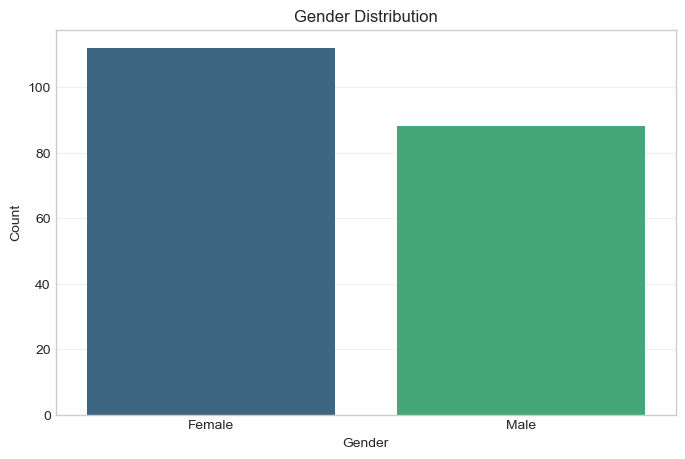

In [50]:
# Distribution of Gender
plt.figure(figsize=(8, 5))
gender_counts = df_copy["Gender"].value_counts()
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    hue=gender_counts.index,
    palette="viridis",
    legend=False,
)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

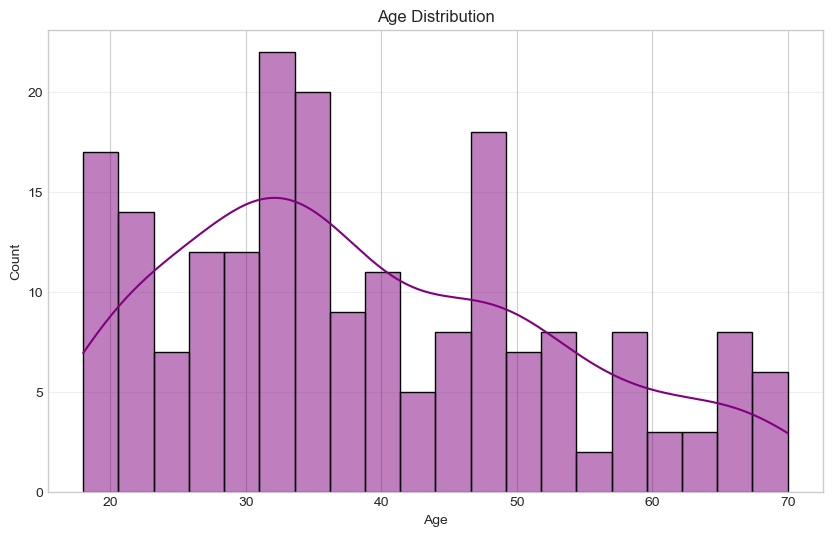

In [51]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_copy["Age"], kde=True, bins=20, color="purple")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

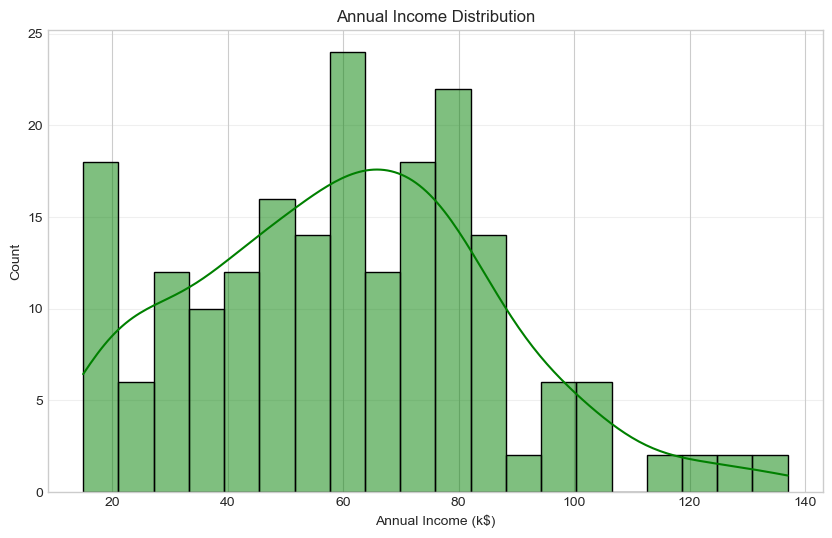

In [52]:
# Income distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_copy["Annual Income (k$)"].values, kde=True, bins=20, color="green")
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

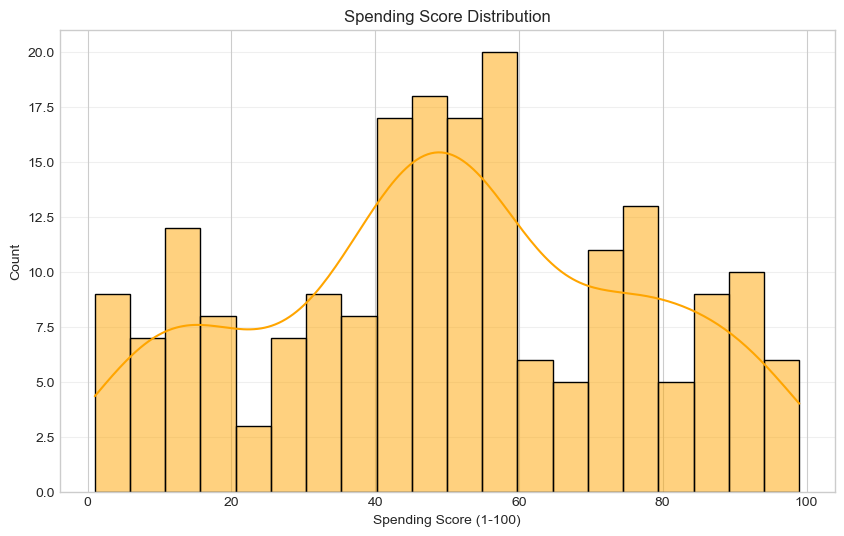

In [53]:
# Spending score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_copy["Spending Score (1-100)"], kde=True, bins=20, color="orange")
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

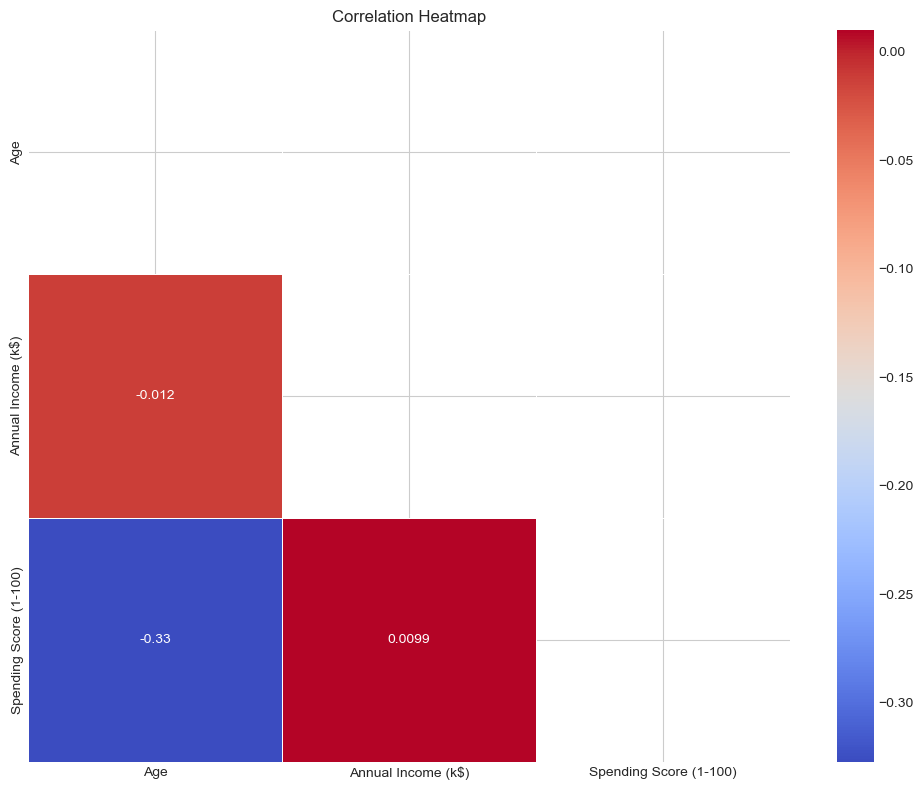

In [54]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = df_copy.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, mask=mask, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

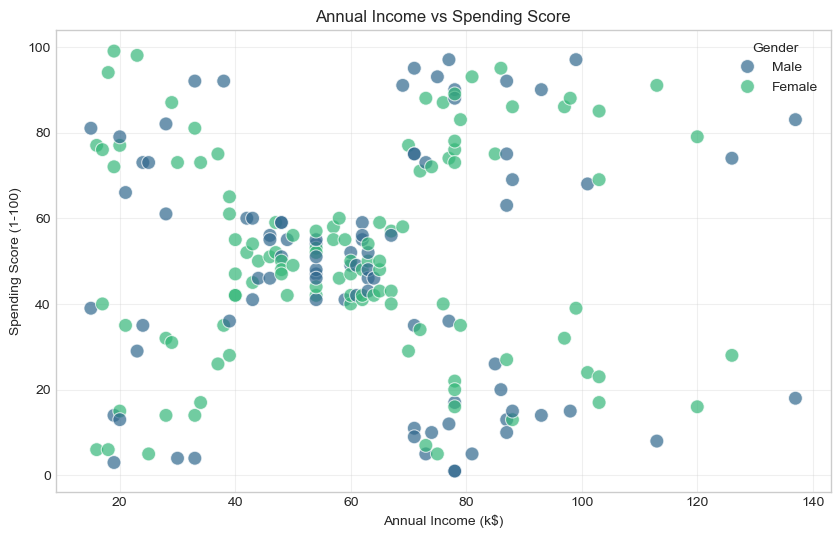

In [55]:
# Scatter plot to see the relationship between Annual Income and Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Gender",
    data=df_copy,
    palette="viridis",
    s=100,
    alpha=0.7,
)
plt.title("Annual Income vs Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(alpha=0.3)
plt.show()

In [56]:
# 3D scatter plot with Age, Annual Income, and Spending Score
fig = px.scatter_3d(
    df_copy,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    z="Age",
    color="Gender",
    opacity=0.7,
    title="3D Scatter Plot: Age, Annual Income, and Spending Score",
)
fig.update_layout(
    scene=dict(
        xaxis_title="Annual Income (k$)",
        yaxis_title="Spending Score (1-100)",
        zaxis_title="Age",
    ),
    width=900,
    height=700,
)
fig.show()

## **Feature Selection and Scaling**

For our clustering analysis, we'll focus on 'Annual Income' and 'Spending Score' as these are the most relevant features for customer segmentation. These two variables are particularly useful because:

1. **Annual Income**: Represents the purchasing power of customers
2. **Spending Score**: Reflects actual spending behavior and loyalty

Feature scaling is a critical preprocessing step for clustering algorithms as they are distance-based and sensitive to the scale of input features. If features are not scaled:

- Features with larger ranges will dominate the distance calculations
- The clustering algorithm might produce biased results
- The convergence of the algorithm might be slower

We'll use StandardScaler from scikit-learn to transform our features to have a mean of 0 and a standard deviation of 1, ensuring that both income and spending score contribute equally to the clustering process.

In [57]:
# Select features for clustering
X = df_copy[["Annual Income (k$)", "Spending Score (1-100)"]].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with the scaled features for easier interpretation
scaled_df = pd.DataFrame(
    X_scaled, columns=["Scaled Annual Income", "Scaled Spending Score"]
)
scaled_df["Annual Income (k$)"] = df_copy["Annual Income (k$)"]
scaled_df["Spending Score (1-100)"] = df_copy["Spending Score (1-100)"]

# Display the first few rows of the scaled data
display(pd.concat([scaled_df.head(), scaled_df.tail()]))

,Scaled Annual Income,Scaled Spending Score,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801,15,39
1,-1.738999,1.195704,15,81
2,-1.700830,-1.715913,16,6
3,-1.700830,1.040418,16,77
4,-1.662660,-0.395980,17,40
195,2.268791,1.118061,120,79
196,2.497807,-0.861839,126,28
197,2.497807,0.923953,126,74
198,2.917671,-1.250054,137,18
199,2.917671,1.273347,137,83


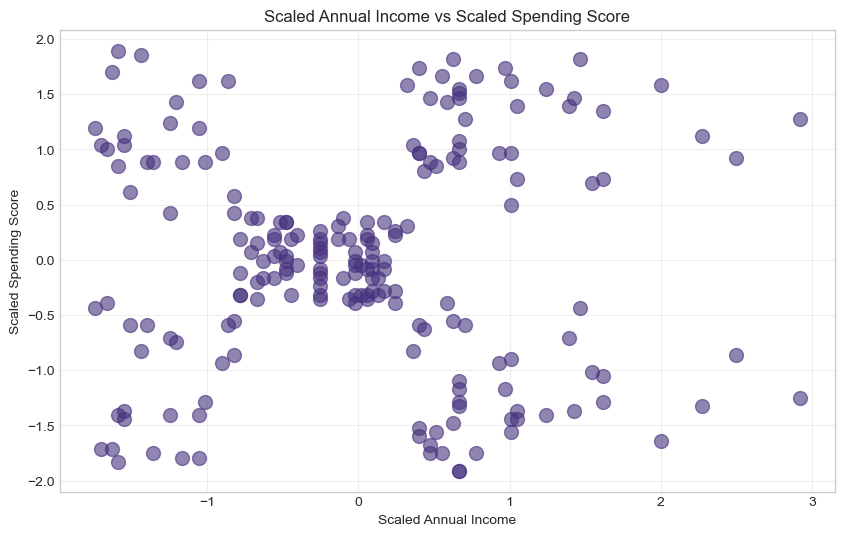

In [58]:
# Visualize the scaled data
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.6, s=100)
plt.title("Scaled Annual Income vs Scaled Spending Score")
plt.xlabel("Scaled Annual Income")
plt.ylabel("Scaled Spending Score")
plt.grid(alpha=0.3)
plt.show()

## **Determining Optimal Number of Clusters**

Before applying the K-means clustering algorithm, we need to determine the optimal number of clusters. Choosing the right number of clusters is crucial as:

- Too few clusters might oversimplify the data and miss important patterns
- Too many clusters might overfit the data, making the segments less actionable
- The right balance provides meaningful and interpretable customer segments

We'll use two common methods to find the best value for K:

1. **The Elbow Method**: Plots the Within-Cluster Sum of Squares (WCSS) against the number of clusters. The "elbow" point (where the rate of decrease sharply changes) suggests the optimal number of clusters. WCSS measures the sum of distances between each point and its assigned cluster centroid.

2. **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, where:
   - Higher values (closer to 1) indicate objects are well matched to their clusters
   - Values near 0 indicate overlapping clusters
   - Negative values indicate objects may be assigned to the wrong cluster

By using both methods together, we can make a more informed decision about the appropriate number of clusters for our customer segmentation.

In [59]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

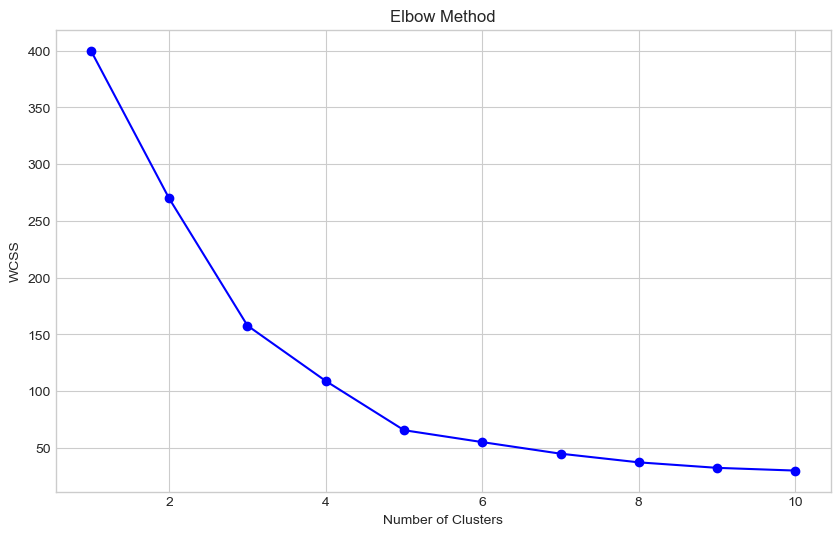

In [60]:
# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Square
for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker="o", linestyle="-", color="blue")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")  # Within Cluster Sum of Squares
plt.grid(True)
plt.show()

For n_clusters = 2, the silhouette score is 0.321
For n_clusters = 3, the silhouette score is 0.467
For n_clusters = 4, the silhouette score is 0.494
For n_clusters = 5, the silhouette score is 0.555
For n_clusters = 6, the silhouette score is 0.540
For n_clusters = 7, the silhouette score is 0.528
For n_clusters = 8, the silhouette score is 0.455
For n_clusters = 9, the silhouette score is 0.457
For n_clusters = 10, the silhouette score is 0.443
For n_clusters = 8, the silhouette score is 0.455
For n_clusters = 9, the silhouette score is 0.457
For n_clusters = 10, the silhouette score is 0.443


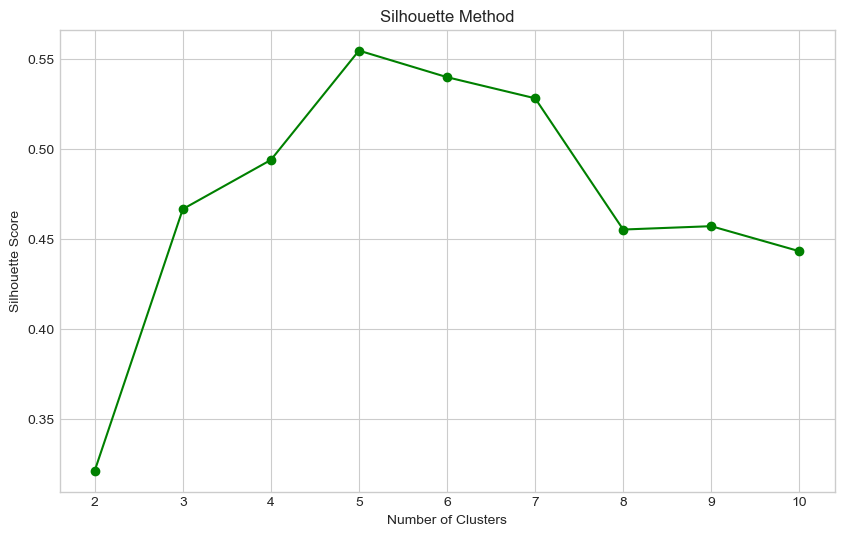

In [61]:
# Computing Silhouette Score for different numbers of clusters
silhouette_scores = []
for i in range(2, 11):  # Silhouette score needs at least 2 clusters
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42
    )
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {i}, the silhouette score is {silhouette_avg:.3f}")

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker="o", linestyle="-", color="green")
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

## **Applying K-means Clustering**

Based on the Elbow Method and Silhouette Score, we'll choose the optimal number of clusters and apply the K-means algorithm to segment our customers.

K-means is one of the most popular clustering algorithms due to its simplicity and efficiency. It works by:

1. Initializing K cluster centroids randomly
2. Assigning each data point to the nearest centroid
3. Recalculating centroids based on the mean of all points assigned to that cluster
4. Repeating steps 2-3 until convergence (centroids no longer move significantly)

We'll use the 'k-means++' initialization method which selects initial centroids that are far apart from each other, leading to better results than random initialization.

After clustering, we'll visualize the results in both 2D and 3D plots to better understand the customer segments. The visualization will help us see:
- How customers are distributed across different segments
- Where the cluster centroids are located
- The boundaries between different customer segments
- The relationship between income, spending score, and age

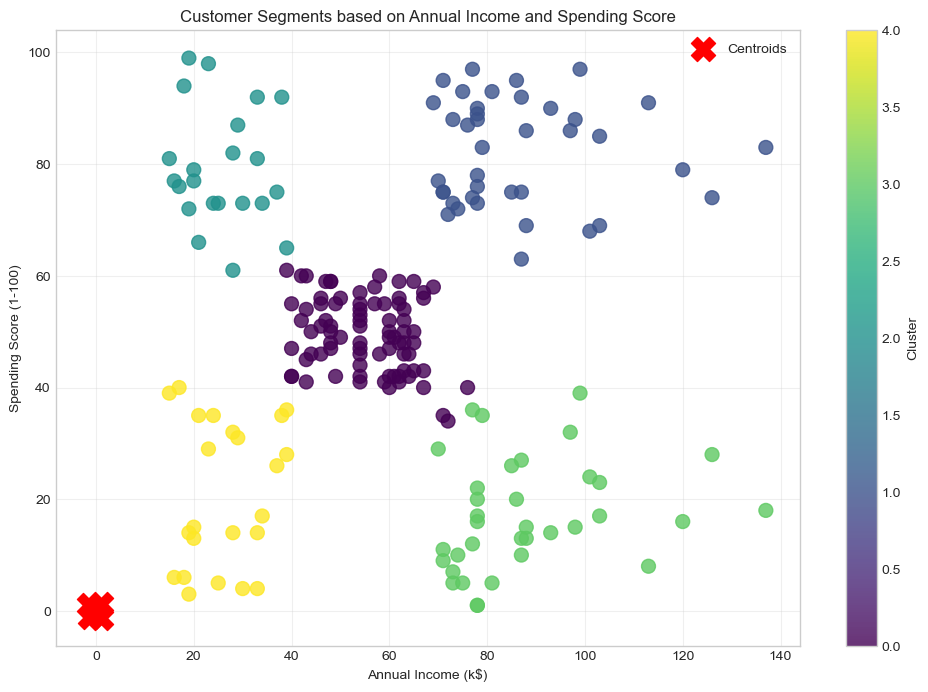

In [62]:
# Based on the Elbow Method and Silhouette Score, let's choose 5 clusters
optimal_k = 5
kmeans = KMeans(
    n_clusters=optimal_k, init="k-means++", max_iter=300, n_init=10, random_state=42
)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to our original dataframe
df_copy["Cluster"] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_copy["Annual Income (k$)"],
    df_copy["Spending Score (1-100)"],
    c=df_copy["Cluster"],
    cmap="viridis",
    s=100,
    alpha=0.8,
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=300,
    c="red",
    marker="X",
    label="Centroids",
)
plt.title("Customer Segments based on Annual Income and Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.colorbar(scatter, label="Cluster")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [63]:
# Create a more interactive 3D visualization with plotly
fig = px.scatter_3d(
    df_copy,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    z="Age",
    color="Cluster",
    symbol="Gender",
    opacity=0.8,
    title="3D Customer Segmentation",
)

# Update layout with improved spacing and margins
fig.update_layout(
    scene=dict(
        xaxis_title="Annual Income (k$)",
        yaxis_title="Spending Score (1-100)",
        zaxis_title="Age",
        # Add more space between axes and labels
        xaxis=dict(
            nticks=10,
            range=[
                df_copy["Annual Income (k$)"].min() - 5,
                df_copy["Annual Income (k$)"].max() + 5,
            ],
        ),
        yaxis=dict(
            nticks=10,
            range=[
                df_copy["Spending Score (1-100)"].min() - 5,
                df_copy["Spending Score (1-100)"].max() + 5,
            ],
        ),
        zaxis=dict(
            nticks=10, range=[df_copy["Age"].min() - 5, df_copy["Age"].max() + 5]
        ),
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),  # Adjust margins
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255,255,255,0.8)",  # Semi-transparent background for better visibility
    ),
)

# Show the plot
fig.show()

## **Cluster Interpretation and Customer Profiling**

Now let's analyze and interpret each cluster to understand the different customer segments. Based on the K-means clustering results, we can identify distinct customer segments with unique characteristics and behaviors.

Each cluster represents a specific customer profile that can help with targeted marketing strategies:

1. **High Income, High Spenders**: These are premium customers who have high income and high spending scores. They are ideal for luxury products and premium services.

2. **High Income, Low Spenders**: These customers have high income but low spending scores. They represent potential for growth through targeted marketing that emphasizes value and quality.

3. **Low Income, High Spenders**: These customers have low income but high spending scores. They might be price-sensitive but value the shopping experience and are willing to spend.

4. **Low Income, Low Spenders**: These customers have low income and low spending scores. They are likely budget-conscious and may respond well to promotions and discounts.

5. **Average Income, Average Spenders**: These customers have moderate income and spending habits. They represent the general market and can be targeted with standard offerings.

Let's look at the detailed statistics for each cluster to confirm these profiles:

In [64]:
# Analyze cluster statistics
cluster_stats = df_copy.groupby("Cluster").agg(
    {
        "Age": ["mean", "min", "max", "count"],
        "Annual Income (k$)": ["mean", "min", "max"],
        "Spending Score (1-100)": ["mean", "min", "max"],
    }
)

# Display the statistics for each cluster
print("Cluster Statistics:")
display(cluster_stats)

# Calculate the percentage of each gender in each cluster
gender_distribution = (
    pd.crosstab(df_copy["Cluster"], df_copy["Gender"], normalize="index") * 100
)
gender_distribution = gender_distribution.round(2)
print("\nGender Distribution in Each Cluster (%):")
display(gender_distribution)

Cluster Statistics:


Age               Annual Income (k$)           \
              mean min max count               mean min  max   
Cluster                                                        
0        42.716049  18  70    81          55.296296  39   76   
1        32.692308  27  40    39          86.538462  69  137   
2        25.272727  18  35    22          25.727273  15   39   
3        41.114286  19  59    35          88.200000  70  137   
4        45.217391  19  67    23          26.304348  15   39   

        Spending Score (1-100)          
                          mean min max  
Cluster                                 
0                    49.518519  34  61  
1                    82.128205  63  97  
2                    79.363636  61  99  
3                    17.114286   1  39  
4                    20.913043   3  40


Gender Distribution in Each Cluster (%):


Gender,Female,Male
Cluster,,
0,59.26,40.74
1,53.85,46.15
2,59.09,40.91
3,45.71,54.29
4,60.87,39.13


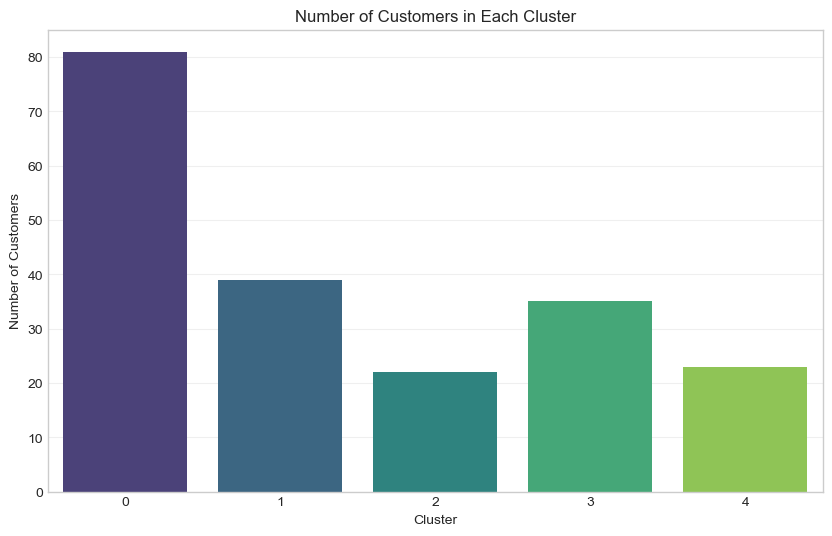

In [65]:
# Visualize cluster sizes
plt.figure(figsize=(10, 6))
cluster_sizes = df_copy["Cluster"].value_counts().sort_index()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="viridis")
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.grid(axis="y", alpha=0.3)
plt.show()

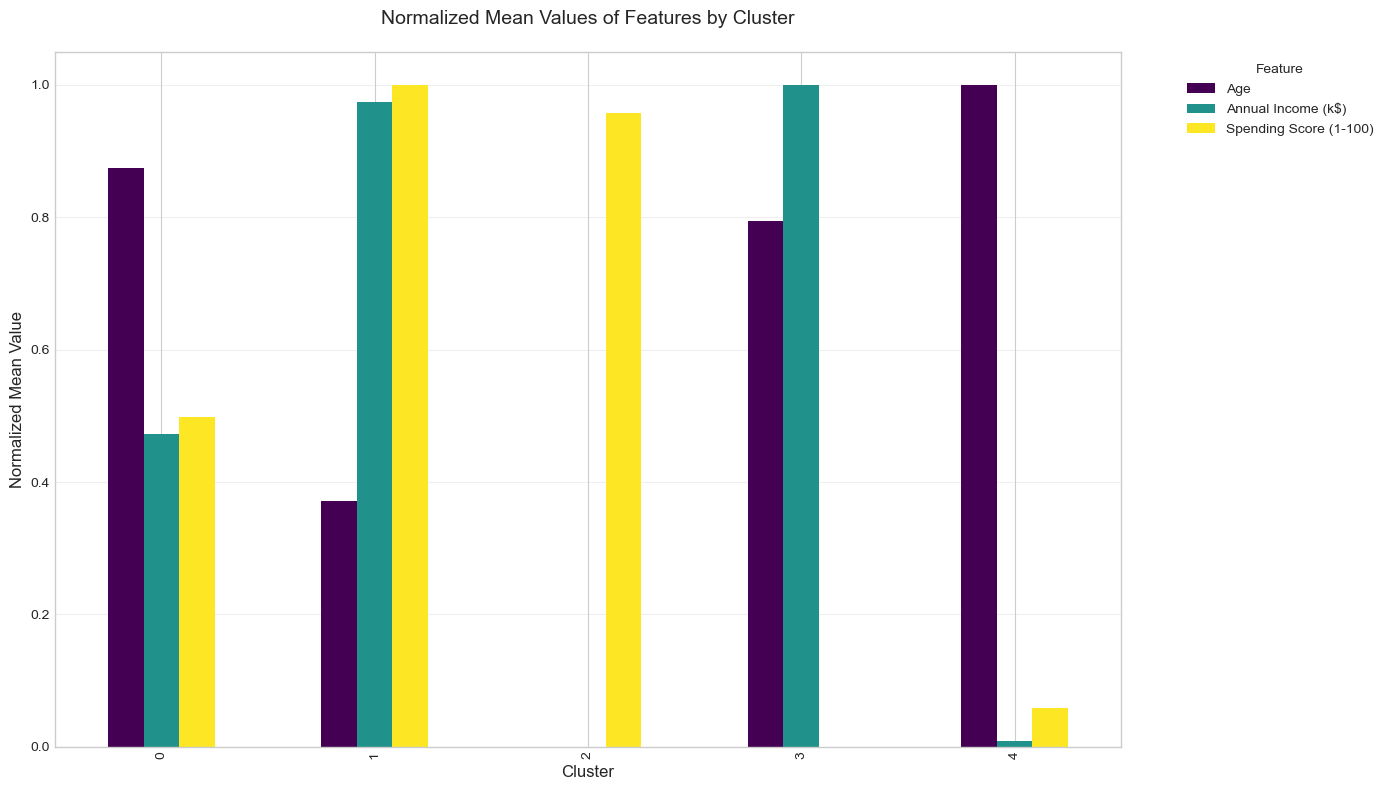

In [66]:
# Plot mean values for each feature by cluster
cluster_means = df_copy.groupby("Cluster")[
    ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
].mean()
cluster_means_normalized = (cluster_means - cluster_means.min()) / (
    cluster_means.max() - cluster_means.min()
)

# Create the figure and axes explicitly
fig, ax = plt.subplots(figsize=(14, 8))
cluster_means_normalized.plot(kind="bar", colormap="viridis", ax=ax)
ax.set_title("Normalized Mean Values of Features by Cluster", fontsize=14, pad=20)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Normalized Mean Value", fontsize=12)
ax.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## **Applying DBSCAN Clustering**

Let's also try DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which can identify clusters of arbitrary shape and automatically detect outliers.

DBSCAN has several advantages over K-means:
- It doesn't require specifying the number of clusters beforehand
- It can find arbitrarily shaped clusters
- It's robust to outliers (marks them as noise)
- It works well when clusters have similar density

The key parameters for DBSCAN are:
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other
- `min_samples`: The number of samples in a neighborhood for a point to be considered as a core point

Let's experiment with different values of `eps` to find the optimal setting for our data:

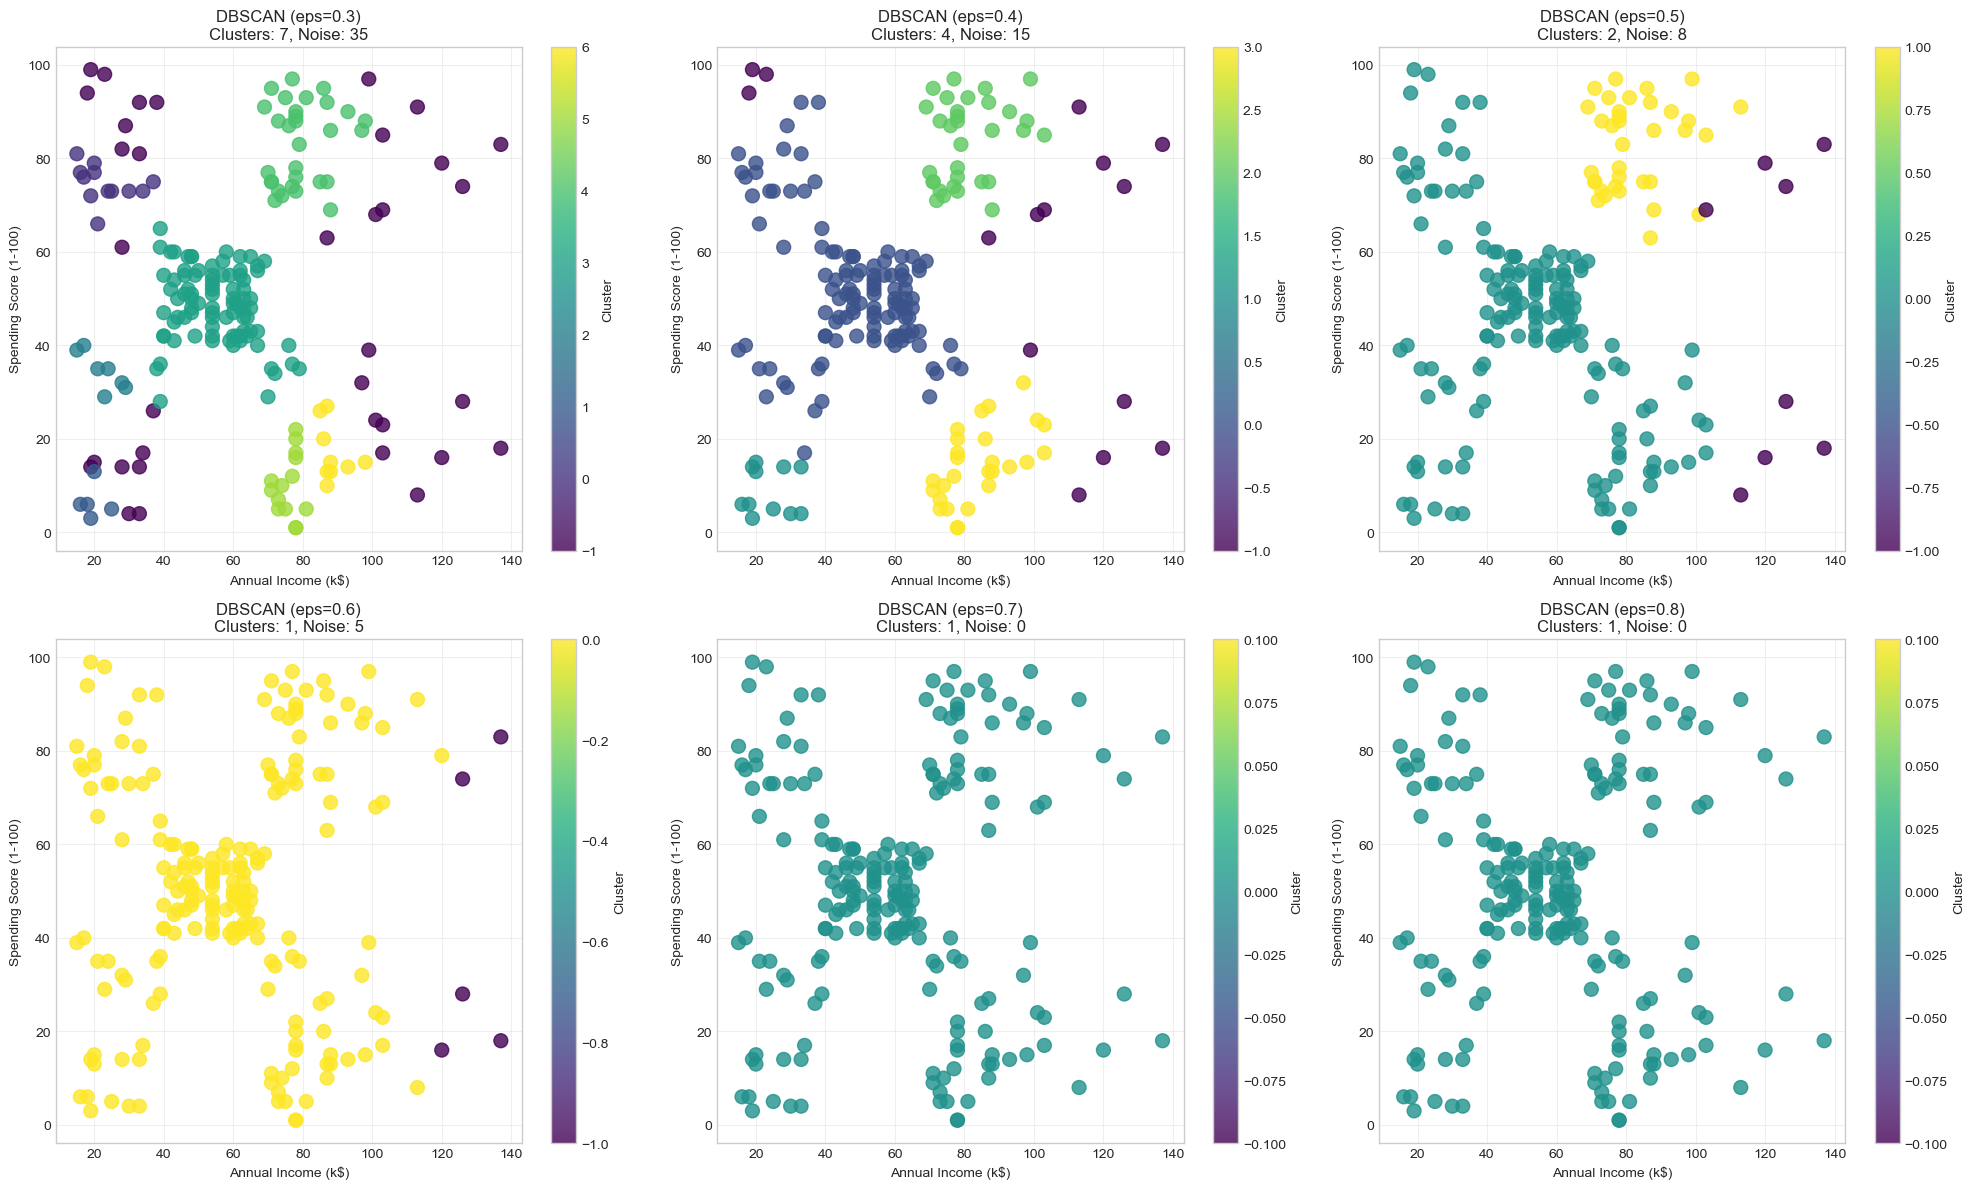

In [67]:
# Testing different epsilon values for DBSCAN
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
min_samples = 5

plt.figure(figsize=(20, 12))
for i, eps in enumerate(eps_values):
    # Apply DBSCAN with the current epsilon value
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    # Count the number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Plot the results
    plt.subplot(2, 3, i+1)
    scatter = plt.scatter(
        df_copy["Annual Income (k$)"], 
        df_copy["Spending Score (1-100)"], 
        c=dbscan_labels, 
        cmap='viridis', 
        s=100, 
        alpha=0.8
    )
    plt.title(f'DBSCAN (eps={eps})\nClusters: {n_clusters}, Noise: {n_noise}')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

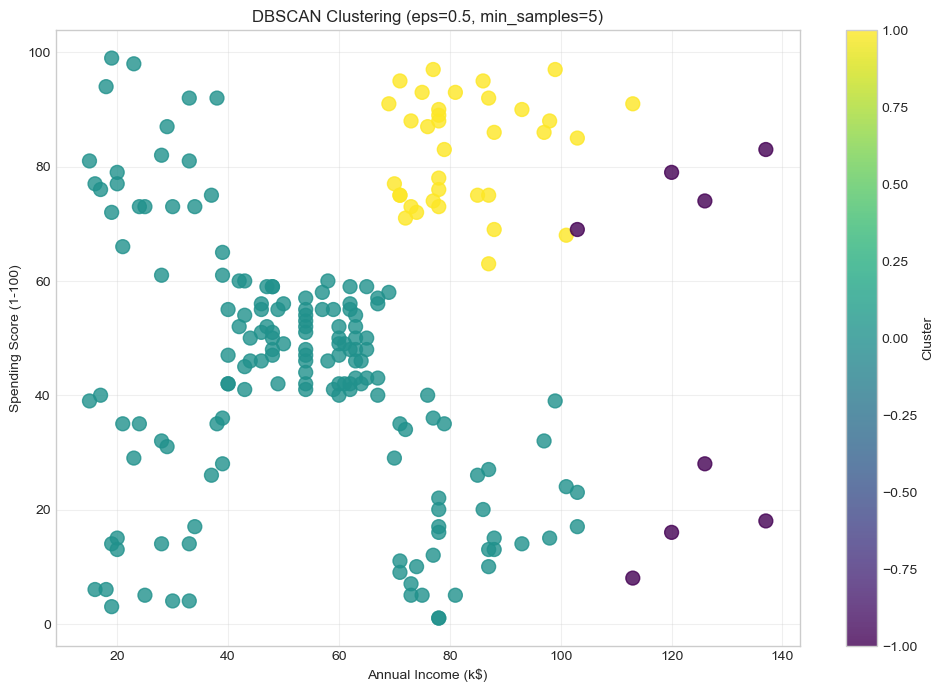

DBSCAN Cluster Sizes:


DBSCAN_Cluster
-1      8
 0    157
 1     35
Name: count, dtype: int64

In [68]:
# Based on the visual assessment, let's choose eps=0.5 as it provides good cluster separation
optimal_eps = 0.5
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Create a copy of the dataframe for DBSCAN results
df_dbscan = df_copy.copy()
df_dbscan["DBSCAN_Cluster"] = dbscan_labels

# Visualize the final DBSCAN clustering
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_dbscan["Annual Income (k$)"],
    df_dbscan["Spending Score (1-100)"],
    c=df_dbscan["DBSCAN_Cluster"],
    cmap="viridis",
    s=100,
    alpha=0.8,
)
plt.title(f"DBSCAN Clustering (eps={optimal_eps}, min_samples={min_samples})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.colorbar(scatter, label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# Count cluster sizes
dbscan_cluster_sizes = df_dbscan["DBSCAN_Cluster"].value_counts().sort_index()
print("DBSCAN Cluster Sizes:")
display(dbscan_cluster_sizes)

# Note: -1 represents noise points that don't belong to any cluster

## **Analyzing Average Spending Per Cluster**

Understanding the spending patterns within each cluster is crucial for developing targeted marketing strategies. Let's analyze and compare the average spending per cluster for both K-means and DBSCAN clustering algorithms.

This analysis will help us:
1. Identify which clusters represent high-value customers
2. Understand the relationship between income and spending behavior
3. Determine which segments should be prioritized for marketing campaigns
4. Compare how different clustering algorithms group customers with similar spending behaviors

The average spending score will be calculated for each cluster along with the minimum and maximum values to understand the range of spending behaviors within each segment. We'll also count the number of customers in each cluster to assess the segment size.

In [69]:
# Calculate average spending per cluster for K-means
kmeans_spending = df_copy.groupby("Cluster")["Spending Score (1-100)"].agg(["mean", "min", "max", "count"])
kmeans_spending.columns = ["Average Spending", "Min Spending", "Max Spending", "Customer Count"]
kmeans_spending = kmeans_spending.sort_values(by="Average Spending", ascending=False)

# Calculate average spending per cluster for DBSCAN
dbscan_spending = df_dbscan.groupby("DBSCAN_Cluster")["Spending Score (1-100)"].agg(["mean", "min", "max", "count"])
dbscan_spending.columns = ["Average Spending", "Min Spending", "Max Spending", "Customer Count"]
dbscan_spending = dbscan_spending.sort_values(by="Average Spending", ascending=False)

# Display the results
print("K-means Average Spending per Cluster:")
display(kmeans_spending)

print("\nDBSCAN Average Spending per Cluster:")
display(dbscan_spending)

K-means Average Spending per Cluster:


,Average Spending,Min Spending,Max Spending,Customer Count
Cluster,,,,
1,82.128205,63,97,39
2,79.363636,61,99,22
0,49.518519,34,61,81
4,20.913043,3,40,23
3,17.114286,1,39,35



DBSCAN Average Spending per Cluster:


,Average Spending,Min Spending,Max Spending,Customer Count
DBSCAN_Cluster,,,,
1,82.800000,63,97,35
-1,46.875000,8,83,8
0,43.101911,1,99,157


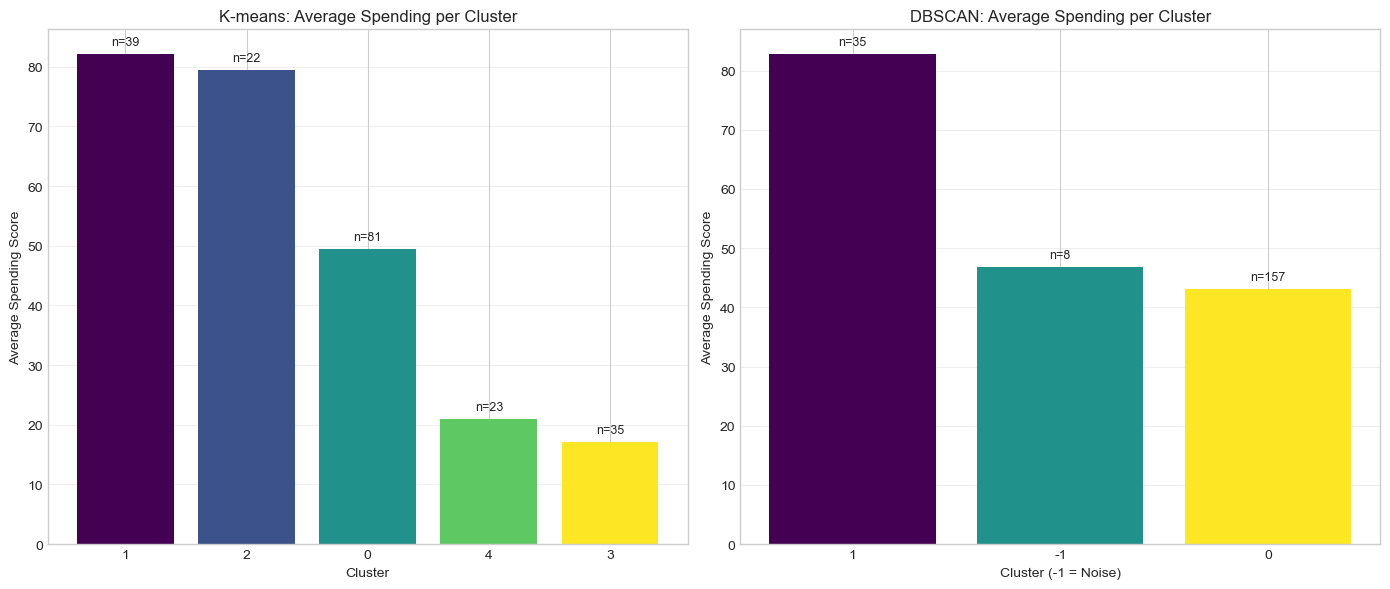

In [72]:
# Visualize average spending per cluster for K-means
plt.figure(figsize=(14, 6))

# Create bar chart for K-means
plt.subplot(1, 2, 1)
kmeans_spending_sorted = kmeans_spending.reset_index()
bars = plt.bar(
    kmeans_spending_sorted["Cluster"].astype(str), 
    kmeans_spending_sorted["Average Spending"],
    color=plt.get_cmap("viridis")(np.linspace(0, 1, len(kmeans_spending_sorted)))
)

# Add count labels on top of bars
for bar, count in zip(bars, kmeans_spending_sorted["Customer Count"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'n={count}',
        ha='center', va='bottom',
        fontsize=9
    )

plt.title("K-means: Average Spending per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending Score")
plt.grid(axis="y", alpha=0.3)

# Create bar chart for DBSCAN
plt.subplot(1, 2, 2)
dbscan_spending_sorted = dbscan_spending.reset_index()
bars = plt.bar(
    dbscan_spending_sorted["DBSCAN_Cluster"].astype(str), 
    dbscan_spending_sorted["Average Spending"],
    color=plt.get_cmap("viridis")(np.linspace(0, 1, len(dbscan_spending_sorted))) 
)

# Add count labels on top of bars
for bar, count in zip(bars, dbscan_spending_sorted["Customer Count"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'n={count}',
        ha='center', va='bottom',
        fontsize=9
    )

plt.title("DBSCAN: Average Spending per Cluster")
plt.xlabel("Cluster (-1 = Noise)")
plt.ylabel("Average Spending Score")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

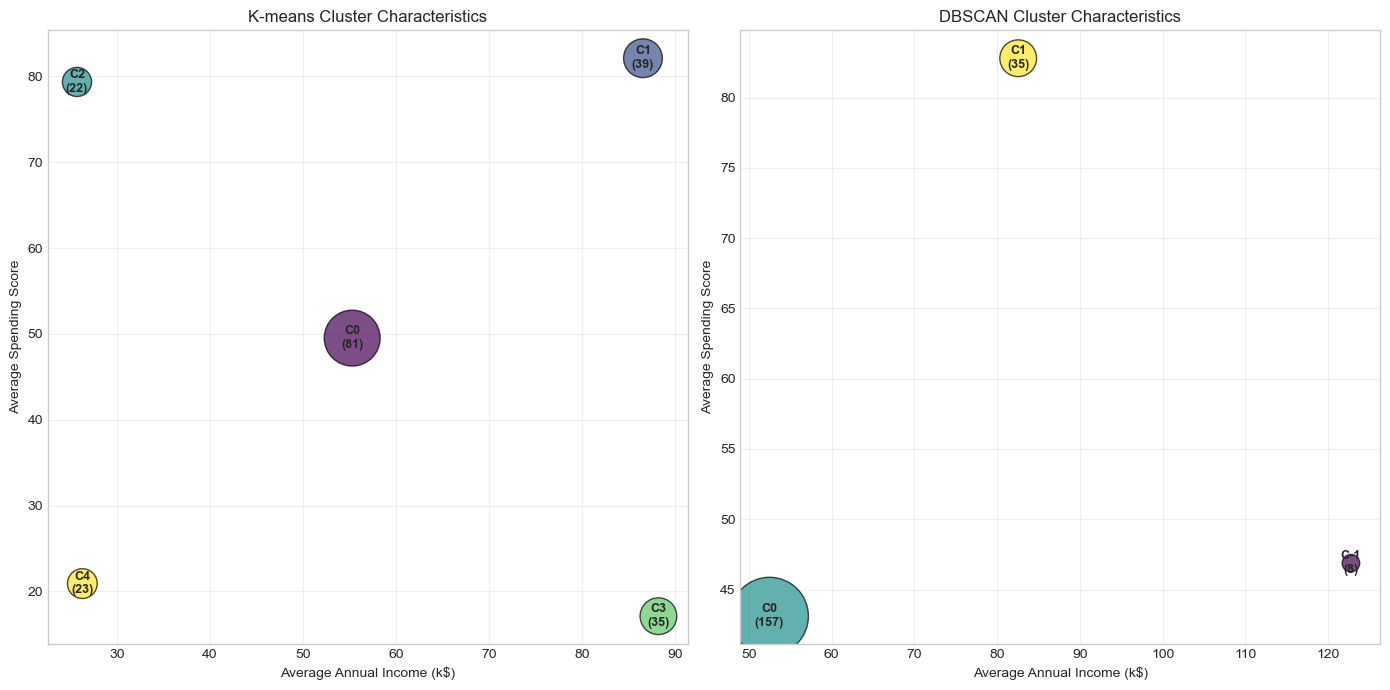

In [71]:
# Create a more advanced visualization to compare cluster characteristics
# Prepare data for visualization
kmeans_avg = df_copy.groupby("Cluster")[["Annual Income (k$)", "Spending Score (1-100)", "Age"]].mean()
dbscan_avg = df_dbscan.groupby("DBSCAN_Cluster")[["Annual Income (k$)", "Spending Score (1-100)", "Age"]].mean()

# Add customer count to the dataframes
kmeans_avg["Customer Count"] = df_copy.groupby("Cluster").size()
dbscan_avg["Customer Count"] = df_dbscan.groupby("DBSCAN_Cluster").size()

# Plot comparison scatter plot with size representing customer count
plt.figure(figsize=(14, 7))

# K-means scatter plot
plt.subplot(1, 2, 1)
plt.scatter(
    kmeans_avg["Annual Income (k$)"],
    kmeans_avg["Spending Score (1-100)"],
    s=kmeans_avg["Customer Count"] * 20,  # Size based on count
    c=kmeans_avg.index,
    cmap="viridis",
    alpha=0.7,
    edgecolors="black"
)

# Add cluster labels
for idx, row in kmeans_avg.iterrows():
    plt.annotate(
        f"C{idx}\n({int(row['Customer Count'])})",
        (row["Annual Income (k$)"], row["Spending Score (1-100)"]),
        ha='center', va='center',
        fontsize=9, fontweight='bold'
    )

plt.title("K-means Cluster Characteristics")
plt.xlabel("Average Annual Income (k$)")
plt.ylabel("Average Spending Score")
plt.grid(alpha=0.3)

# DBSCAN scatter plot
plt.subplot(1, 2, 2)
plt.scatter(
    dbscan_avg["Annual Income (k$)"],
    dbscan_avg["Spending Score (1-100)"],
    s=dbscan_avg["Customer Count"] * 20,  # Size based on count
    c=dbscan_avg.index,
    cmap="viridis", 
    alpha=0.7,
    edgecolors="black"
)

# Add cluster labels
for idx, row in dbscan_avg.iterrows():
    plt.annotate(
        f"C{idx}\n({int(row['Customer Count'])})",
        (row["Annual Income (k$)"], row["Spending Score (1-100)"]),
        ha='center', va='center',
        fontsize=9, fontweight='bold'
    )

plt.title("DBSCAN Cluster Characteristics")
plt.xlabel("Average Annual Income (k$)")
plt.ylabel("Average Spending Score")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Comparison of Clustering Algorithms and Business Insights**

Now that we've applied both K-means and DBSCAN to our customer data, let's compare their results:

1. **K-means Clustering**:
   - Produced well-defined clusters with clear centroids
   - Required us to specify the number of clusters (k=5)
   - Created clusters of similar sizes and shapes
   - All data points are assigned to a cluster
   - More intuitive for business interpretation

2. **DBSCAN Clustering**:
   - Identified clusters of varying shapes and densities
   - Automatically detected the number of clusters based on data density
   - Identified outliers/noise points (cluster -1)
   - More sensitive to parameter selection (eps and min_samples)
   - Better at finding natural groupings in the data

### **Key Business Insights from Customer Segmentation:**

1. **Target High-Value Customers:** Clusters with high spending scores represent our most valuable customers. We should develop retention strategies specifically for these segments.

2. **Growth Opportunities:** Clusters with high income but low spending scores present significant growth opportunities. Targeted marketing campaigns showcasing premium products and services could convert them into high spenders.

3. **Budget-Conscious Segments:** Clusters with lower income require different marketing approaches focused on value, discounts, and affordable products.

4. **Outlier Analysis:** The noise points identified by DBSCAN are customers with unique behaviors that don't fit into standard segments. These may require personalized approaches or further investigation.

### **Recommended Marketing Strategies:**

1. **Premium Customer Strategy:** For high income, high spending customers, implement loyalty programs, exclusive offers, and premium product recommendations.

2. **Conversion Strategy:** For high income, low spending customers, focus on demonstrating product value, quality assurance, and premium experiences to increase their spending.

3. **Value-Oriented Strategy:** For low income, high spending customers, offer installment plans, membership benefits, and reward programs to maintain their engagement.

4. **Budget Strategy:** For low income, low spending customers, provide discounts, promotions, and budget-friendly alternatives to increase purchase frequency.

5. **General Market Strategy:** For average income, average spending customers, maintain competitive pricing and diverse product offerings.

This customer segmentation analysis provides a foundation for data-driven marketing decisions and personalized customer experiences, which can significantly improve marketing ROI and customer satisfaction.